In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Train the ML model
from utils import sample_files, load_encoder_data, plot_loss
from utils import fast_tensor_load

import time
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl


2023-09-11 16:06:45.490996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 16:06:55.231405: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 16:06:58.063487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-09-11 16:06:58

In [3]:
IMG_OUTPUT_SIZE = 128
DATA_LOAD_METHOD='FAST_TENSOR' # it can be TENSOR or DATASET or FAST_TENSOR

num_Turns_Case = 1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = './tomo_data/datasets_encoder_TF_24-03-23'

# data_dir = './tomo_data/datasets'
timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
print('Using timestamp: ', timestamp)



Using timestamp:  2023_09_11_16-08-06


In [4]:

# Train specific
train_cfg = {
    'epochs': 50,
    'filters': [8, 16, 32],
    'cropping': [0, 0],
    'kernel_size': 3,
    'strides': [2, 2],
    'activation': 'relu',
    'conv_padding': 'same',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.1,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'use_bias': True,
    'normalization': 'minmax',
    'img_normalize': 'off',
    'batch_size': 128
}


In [6]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[device_to_use], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[device_to_use],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


No GPU available, using the CPU


In [7]:
np.random.seed(42)

start_t = time.time()

assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'validation-??.npz')

x_train, y_train = fast_tensor_load(TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, y_valid = fast_tensor_load(VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))

end_t = time.time()
print(
    f'\n---- Input files have been read, elapsed: {end_t - start_t} ----\n')


Loading ./tomo_data/datasets_encoder_TF_24-03-23/ML_data/training-00.npz


2023-09-11 16:09:12.716641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Training files:  15898
Loading ./tomo_data/datasets_encoder_TF_24-03-23/ML_data/validation-00.npz
Number of Validation files:  1404

---- Input files have been read, elapsed: 16.254546403884888 ----



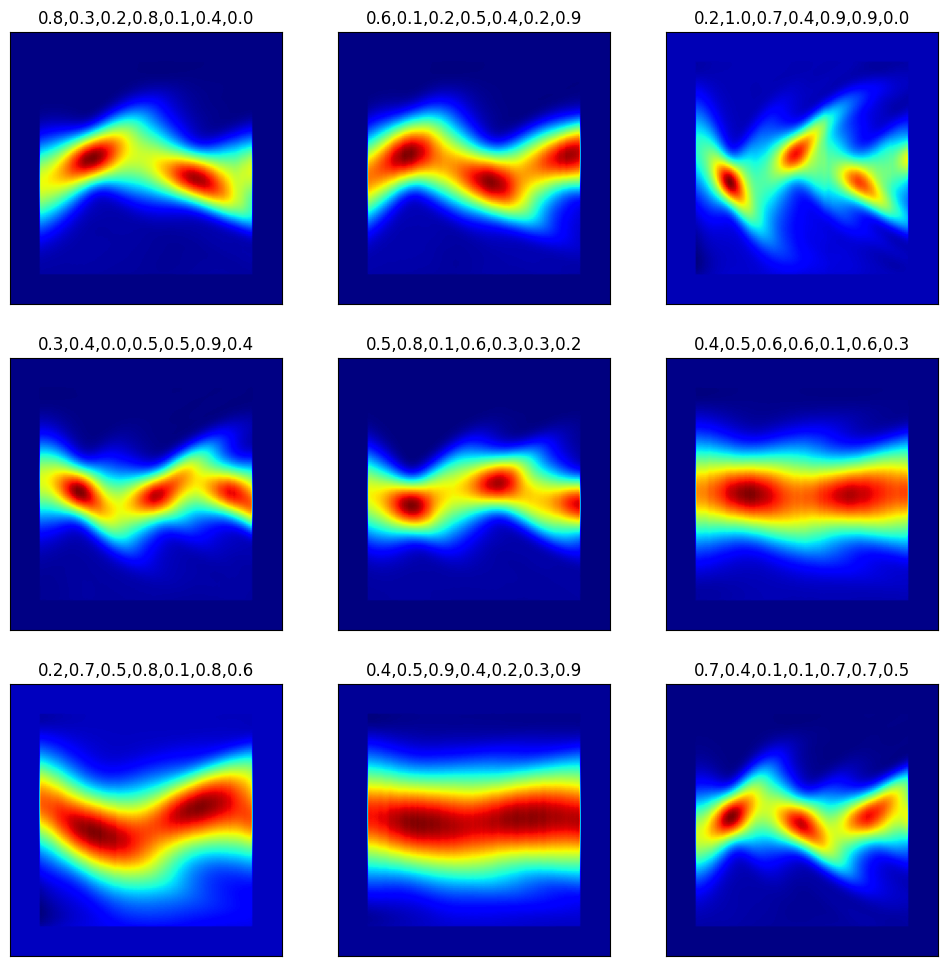

In [8]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [9]:
# model definition
class CVAE(keras.Model):
    """Convolutional variational autoencoder."""

    # Pooling can be None, or 'Average' or 'Max'
    def __init__(self, output_name='vae',
                 input_shape=(128, 128, 1), latent_dim=2,
                 cropping=[[0, 0], [0, 0]], 
                 filters=[8, 16, 32],  kernel_size=3, conv_padding='same', 
                 strides=[2, 2], activation='relu',
                 final_activation='linear', final_kernel_size=3,
                 pooling=None, pooling_size=[2, 2],
                 pooling_strides=[1, 1], pooling_padding='valid',
                 dropout=0.0, learning_rate=0.001, loss='mse',
                 metrics=[], use_bias=True, batchnorm=False,
                 **kwargs):
        super().__init__()

        self.output_name = output_name
        self.inputShape = input_shape
        # the kernel_size can be a single int or a list of ints
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * len(filters)
        assert len(kernel_size) == len(filters)

        # the strides can be a list of two ints, or a list of two-int lists
        if isinstance(strides[0], int):
            strides = [strides for _ in filters]
        assert len(strides) == len(filters)

        # set the input size
        inputs = keras.Input(shape=input_shape, name='Input', dtype='float32')
        # this is the autoencoder case
        # crop the edges
        cropped = keras.layers.Cropping2D(
            cropping=cropping, name='Crop')(inputs)
        x = cropped

        # For evey Convolutional layer
        for i, f in enumerate(filters):
            # Add the Convolution
            x = keras.layers.Conv2D(
                filters=f, kernel_size=kernel_size[i], strides=strides[i],
                use_bias=use_bias, padding=conv_padding,
                name=f'CNN_{i+1}')(x)

            # Apply batchnormalization
            if batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Apply the activation function
            x = keras.activations.get(activation)(x)

            # Optional pooling after the convolution
            if pooling == 'Max':
                x = keras.layers.MaxPooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'MaxPooling_{i+1}')(x)
            elif pooling == 'Average':
                x = keras.layers.AveragePooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'AveragePooling_{i+1}')(x)

        # we have reached the latent space
        last_shape = x.shape[1:]
        x = keras.layers.Flatten(name='Flatten')(x)
        flat_shape = x.shape[1:]
        # Now we add the dense layers
        x = keras.layers.Dense(units=2 * latent_dim, name=f'dense_enc')(x)
        self.encoder = keras.Model(inputs=inputs, outputs=x, name='encoder')

        decoder_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')
        x = keras.layers.Dense(units=np.prod(flat_shape), activation=activation,
                            name=f'dense_dec')(decoder_inputs)
            

        # Now reshape back to last_shape
        x = keras.layers.Reshape(target_shape=last_shape, name='Reshape')(x)
        # Now with transpose convolutions we go back to the original size
        
        for i, f in enumerate(filters[::-1]):
            x = keras.layers.Conv2DTranspose(
                filters=f, kernel_size=kernel_size[-i-1], strides=strides[-i-1],
                use_bias=use_bias, padding=conv_padding,
                name=f'CNN_Transpose_{i+1}')(x)
        
        # final convolution to get the right number of channels
        x = keras.layers.Conv2DTranspose(filters=1, kernel_size=final_kernel_size, 
                strides=1, use_bias=use_bias, padding='same',
                name=f'CNN_Transpose_Final')(x)
        
        self.decoder = keras.Model(inputs=decoder_inputs, outputs=x, name='decoder')
        # outputs = keras.layers.Activation(activation=final_activation, 
        #             name='final_activation')(x)

        # model = keras.Model(inputs=inputs, outputs=outputs)

        # assert model.layers[-1].output_shape[1:] == input_shape

        # Also initialize the optimizer and compile the model
        # optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        # model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # self.model = model
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    # def predict(self, wf_in):
    #     wf_out = self.model(wf_in)
    #     return wf_out

    def load(self, weights_file):
        self.model = keras.models.load_model(weights_file)

    def save(self, weights_file):
        self.model.save(weights_file)



    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        # cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(x_logit, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)


    @tf.function
    def train_step(self, x):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))


In [12]:
# Model instantiation
start_t = time.time()

vae = CVAE(input_shape=x_train.shape[1:])
vae.compile(optimizer=vae.optimizer)

# print(vae.model.summary())

print(
    f'\n---- Models have been initialized, elapsed: {time.time() - start_t} ----\n')


---- Models have been initialized, elapsed: 1.3947601318359375 ----



In [14]:
vae.fit(x=x_train,
         epochs=train_cfg['epochs'], batch_size=train_cfg['batch_size'])

Epoch 1/50


ValueError: in user code:

    File "/afs/cern.ch/work/k/kiliakis/git/mlp-lhc-tomography/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_172833/2654969962.py", line 166, in train_step  *
        loss = self.compute_loss(x)
    File "/tmp/ipykernel_172833/2654969962.py", line 149, in compute_loss  *
        z = self.reparameterize(mean, logvar)
    File "/tmp/ipykernel_172833/2654969962.py", line 118, in reparameterize  *
        eps = tf.random.normal(shape=mean.shape)

    ValueError: Cannot convert a partially known TensorShape (None, 2) to a Tensor.


In [11]:
input_wf = x_train[0:1]
output_wf = autoenc.predict(input_wf)
print(input_wf.shape, output_wf.shape)

(1, 128, 128, 1) (1, 128, 128, 1)


In [44]:

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder.h5'),
                                            monitor='val_loss', save_best_only=True)

start_time = time.time()

history = autoenc.model.fit(
    # x=x_train, y=x_train, 
    # validation_data=(x_valid, x_valid),
    x=y_train, y=x_train, 
    validation_data=(y_valid, x_valid),
    epochs=train_cfg['epochs'],
    callbacks=[stop_early], 
    batch_size=train_cfg['batch_size'],
    verbose=1)

total_time = time.time() - start_time
print(
        f'\n---- Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')


Epoch 1/50
125/125 [==============================] - 10s 76ms/step - loss: 0.0013 - val_loss: 3.4759e-04
Epoch 2/50
125/125 [==============================] - 9s 75ms/step - loss: 2.6975e-04 - val_loss: 1.8827e-04
Epoch 3/50
125/125 [==============================] - 9s 74ms/step - loss: 1.6027e-04 - val_loss: 1.3287e-04
Epoch 4/50
125/125 [==============================] - 10s 78ms/step - loss: 1.1789e-04 - val_loss: 1.0595e-04
Epoch 5/50
125/125 [==============================] - 10s 76ms/step - loss: 9.7583e-05 - val_loss: 8.6504e-05
Epoch 6/50
125/125 [==============================] - 10s 76ms/step - loss: 8.7458e-05 - val_loss: 7.5821e-05
Epoch 7/50
125/125 [==============================] - 9s 76ms/step - loss: 7.6568e-05 - val_loss: 8.0676e-05
Epoch 8/50
125/125 [==============================] - 9s 76ms/step - loss: 7.2439e-05 - val_loss: 7.1295e-05
Epoch 9/50
125/125 [==============================] - 9s 76ms/step - loss: 6.8578e-05 - val_loss: 6.6534e-05
Epoch 10/50
125/125

In [ ]:
def plot_sample(samples, autoenc, figname=None):

    ncols = len(samples)
    # Get nrows * nrows random images
    # sample = np.random.choice(np.arange(len(x_train)),
    #                         size=ncols, replace=False)

    samples_X = tf.gather(x_train, samples)
    pred_samples_X = autoenc.predict(samples_X)
    # samples_y = tf.gather(y_train, sample)

    # Create 3x3 grid of figures
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(14, 7))
    # axes = np.ravel(axes)
    for i in range(ncols):
        ax = axes[0, i]
        ax.set_xticks([])
        ax.set_yticks([])
        # show the image
        ax.imshow(samples_X[i], cmap='jet')
        # Set the label
        ax.set_title(f'Real')

        ax = axes[1, i]
        ax.set_xticks([])
        ax.set_yticks([])
        # show the image
        ax.imshow(pred_samples_X[i], cmap='jet')
        # Set the label
        ax.set_title(f'Pred, MSE: {np.mean((samples_X[i] - pred_samples_X[i])**2):.2e}')
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
    else:
        plt.show()
    plt.close()

In [ ]:
config_dict = {}
config_dict['model'] = train_cfg.copy()

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20, restore_best_weights=True)
# save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder.h5'),
#                                             monitor='val_loss', save_best_only=True)

for dense_units in [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]:
# for dense_units in [1, 2]:

    train_cfg['dense_layers'] = [dense_units]
    autoenc = AutoEncoder(**train_cfg)

    print("----- Model Initialized, training with dense units: ", dense_units)
    start_time = time.time()

    history = autoenc.model.fit(
        x=x_train, y=x_train, 
        epochs=train_cfg['epochs'],
        validation_data=(x_valid, x_valid),
        callbacks=[stop_early], 
        batch_size=train_cfg['batch_size'],
        verbose=0)

    total_time = time.time() - start_time
    print(
            f'\n---- {dense_units}: Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')

    # Plot training and validation loss
    print('\n---- Plotting loss ----\n')

    train_loss_l = np.array(history.history['loss'])
    valid_loss_l = np.array(history.history['val_loss'])

    plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
                title='Encoder Train/Validation Loss',
                figname=os.path.join(plots_dir, f'units{dense_units}_train_valid_loss.png'))

    # Plot some samples
    plot_sample([0, 1, 2, 3], autoenc,
                figname=os.path.join(plots_dir, f'units{dense_units}_samples.png'))

    # save file with experiment configuration
    config_dict[f'{dense_units}'] = {
        'epochs': len(history.history["loss"]),
        'min_train_loss': float(np.min(train_loss_l)),
        'min_valid_loss': float(np.min(valid_loss_l)),
        'total_train_time': total_time,
        'used_gpus': len(gpus)
    }

# save config_dict
with open(os.path.join(trial_dir, 'autoencoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)




---- Plotting loss ----



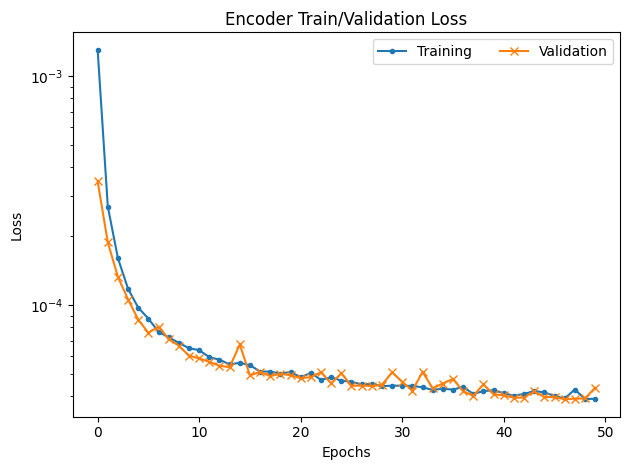

In [68]:
%matplotlib inline

# Plot training and validation loss
print('\n---- Plotting loss ----\n')

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
            title='Encoder Train/Validation Loss')
            # figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))

In [ ]:
ncols = 4
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=ncols, replace=False)

samples_X = tf.gather(x_train, sample)
pred_samples_X = autoenc.predict(samples_X)
# samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(14, 7))
# axes = np.ravel(axes)
for i in range(ncols):
    ax = axes[0, i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    ax.set_title(f'Real')

    ax = axes[1, i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(pred_samples_X[i], cmap='jet')
    # Set the label
    ax.set_title(f'Pred, MSE: {np.mean((samples_X[i] - pred_samples_X[i])**2):.2e}')

In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'epochs': len(history.history["loss"]),
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
})

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)


The following is used to plot the performance of the models with increasingly larger parameter space. 

Text(0.5, 1.0, 'Validation Loss vs Number of Dense Units')

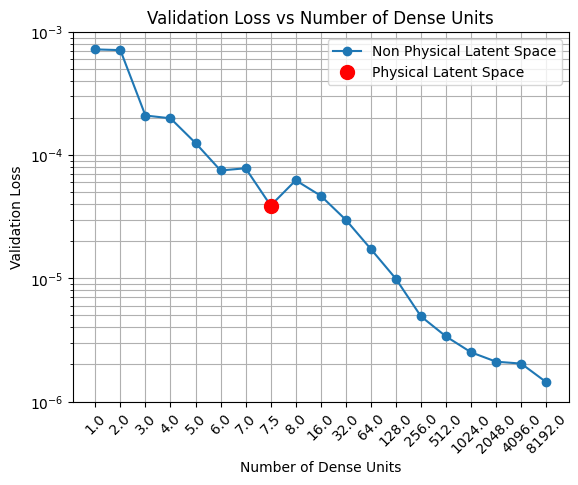

In [69]:
# read the yml config file
file_name = os.path.join('trials/2023_09_06_11-19-37', 'autoencoder-summary.yml')
with open(file_name, 'r') as configfile:
    config_dict = yaml.load(configfile, Loader=yaml.FullLoader)

# get the keys and times
x_val = []
y_val = []
for key, val in config_dict.items():
    if (key not in ['model', 'timestamp']):
        if '-' in key:
            x_val.append(int(key.split('-')[0]) + 0.5)
        else: 
            x_val.append(int(key))
        # if (isinstance(key, int)):
        #     x_val.append(key)
        # else:
        y_val.append(val['min_valid_loss'])

# sort the values based on the keys
x_val = np.array(x_val)
y_val = np.array(y_val)
idx = np.argsort(x_val)
x_val = x_val[idx]
y_val = y_val[idx]

# plot the values in a log y scale
fig, ax = plt.subplots()
# add grid
ax.grid(which='both', axis='both')
# add y axis minor tick labels
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])

xticks = np.arange(len(x_val))

ax.semilogy(xticks, y_val, 'o-', label='Non Physical Latent Space')
# get index of 7.5
idx = np.where(x_val == 7.5)[0][0]
ax.semilogy(xticks[idx], y_val[idx], 'ro', markersize=10, label='Physical Latent Space')
# annotate the points with the y values
# for i, (x, y) in enumerate(zip(xticks, y_val)):
#     ax.annotate(f'{y:.1e}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

ax.set_xticks(xticks, x_val, rotation=45)
plt.legend()
# set the y-axis limits from 10-6 to 10-3
ax.set_ylim([1e-6, 1e-3])
ax.set_xlabel('Number of Dense Units')
ax.set_ylabel('Validation Loss')
ax.set_title('Validation Loss vs Number of Dense Units')